Analyze the results from LSTM

In [1]:
run_python_script = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

if not run_python_script:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
import models.lstm
importlib.reload(models.lstm)

<module 'models.lstm' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/lstm.py'>

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Data, fn and paras

In [7]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
psd_all = 10 * np.log10(psd_all)
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [8]:
freqs

array([ 2.7244898 ,  3.83673469,  4.94897959,  6.06122449,  7.17346939,
        8.28571429,  9.39795918, 10.51020408, 11.62244898, 12.73469388,
       13.84693878, 14.95918367, 16.07142857, 17.18367347, 18.29591837,
       19.40816327, 20.52040816, 21.63265306, 22.74489796, 23.85714286,
       24.96938776, 26.08163265, 27.19387755, 28.30612245, 29.41836735,
       30.53061224, 31.64285714, 32.75510204, 33.86734694, 34.97959184,
       36.09183673, 37.20408163, 38.31632653, 39.42857143, 40.54081633,
       41.65306122, 42.76530612, 43.87755102, 44.98979592])

In [9]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [10]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = np.array(["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"])

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [11]:
std_fn = lambda x: (x-x.mean(axis=-1, keepdims=True))/x.std(axis=-1, keepdims=True)

<function __main__.<lambda>(x)>

In [12]:
# functions to generate training sample (Apr 1, 2023)
def random_choice(n, batchsize=1, len_seg=None):
    """Randomly select the lower and upper bound of the segment
        args:
            n: len of the total time series
    """
    if len_seg is None:
        len_seg = torch.randint(low=10, high=100, size=(1, ))
    up_bd = torch.randint(low=len_seg.item(), high=n, size=(batchsize, ))
    low_bd = up_bd - len_seg
    return low_bd, up_bd


def random_samples_rnn(X, Y=None, batchsize=1, 
                       bds=None, 
                       is_std=True, 
                       theta2raw_fn=None):
    """Randomly select a sample from the whole segment
        args:
            X: PSD, num_seq x 68 x nfreq or 
               PSD, num_sub x num_seq x 68 x nfreq
            Y: params, num x 7, in original sgm scale
        return:
            X_seqs: len_seq x batchsize x num_fs
            Y_seqs: len_seq x batchsize x 7
            
    """
    if X.ndim == 4:
        # if multiple subjects, pick up a subject
        num_sub = X.shape[0]
        sub_idx = np.random.randint(low=0, high=num_sub)
        X = X[sub_idx]
        
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    if is_std:
        #X = X/X.std(axis=(1, 2), keepdims=True)
        # Let std for each ROI and each data
        X = (X-X.mean(axis=2, keepdims=True))/X.std(axis=2, keepdims=True)
    if Y is not None:
        if not isinstance(Y, torch.Tensor):
            Y = torch.tensor(Y)
        if theta2raw_fn: 
            Y = theta2raw_fn(Y)
    if bds is None:
        low_bds, up_bds = random_choice(len(X), batchsize)
    else:
        low_bds, up_bds = bds

    X = X.flatten(1)
    X_seqs = []
    Y_seqs = []
    for low_bd, up_bd in zip(low_bds, up_bds):
        X_seq = X[low_bd:up_bd, :].unsqueeze(1)
        X_seqs.append(X_seq)
        if Y is not None:
            Y_seq = Y[low_bd:up_bd].unsqueeze(1)
            Y_seqs.append(Y_seq)
    if Y is not None:
        return torch.cat(X_seqs, dim=1), torch.cat(Y_seqs, dim=1)
    else:
        return torch.cat(X_seqs, dim=1)
        

In [13]:
def ana_corr(data_org, data_rec):
    corrs_psd = []
    for ix in range(data_org.shape[0]):
        seq_x = data_org[ix]
        seq_y = data_rec[ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_psd.append(res[0])
        
        
    data_org_std = std_mat(data_org)
    data_rec_std = std_mat(data_rec)
    corr_psd_uni = scipy.stats.pearsonr(
        data_org_std.mean(axis=0), 
        data_rec_std.mean(axis=0))[0]
    
    corrs_sp = []
    for ix in range(data_org.shape[1]):
        seq_x = data_org[:, ix]
        seq_y = data_rec[:, ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_sp.append(res[0])
    return corr_psd_uni, corrs_psd, corrs_sp

# Load the model

In [14]:
trained_model_sgm = load_pkl_folder2dict(RES_ROOT/"SGM_net_large", excluding=['opt*']);
sgm_net = trained_model_sgm.model;

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/paras.pkl


In [49]:
fixed = "_wmse"
trained_model_lstm = load_pkl_folder2dict(RES_ROOT/f"LSTM_simu_net{fixed}", excluding=['opt*', "loss_fn"]);
lstm_net = trained_model_lstm.model;

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_wmse/Rec_PSD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_wmse/corrss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_wmse/corrss_roiwise.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_wmse/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_wmse/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_wmse/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_wmse/sgm_paramss_est.pkl


## Evaluate

### sgm parameters

In [50]:
trained_model_lstm.Rec_PSD.shape

(36, 360, 68, 39)

In [51]:
dy_mask = np.array(trained_model_lstm.paras.dy_mask)

array([1, 1, 1, 1, 1, 1, 0])

In [52]:
if "sgm_paramss_est" not in trained_model_lstm.keys():
    trained_model_lstm.model.eval()
    sgm_paramss_est = []
    for data_idx  in trange(36):
        cur_data = psd_all[:, :, :, data_idx].transpose(2, 0, 1)
        X_test = random_samples_rnn(cur_data,
                                    bds=[[0], [360]],
                                    theta2raw_fn=None)
        with torch.no_grad():
            Y_pred = trained_model_lstm.model(X_test).squeeze()
            sgm_paramss_est.append(Y_pred.numpy())
    sgm_paramss_est = np.array(sgm_paramss_est);
    
    trained_model_lstm.sgm_paramss_est = sgm_paramss_est
    save_pkl_dict2folder(RES_ROOT/f"LSTM_simu_net{fixed}", trained_model_lstm, is_force=False)
else:
    sgm_paramss_est = trained_model_lstm.sgm_paramss_est

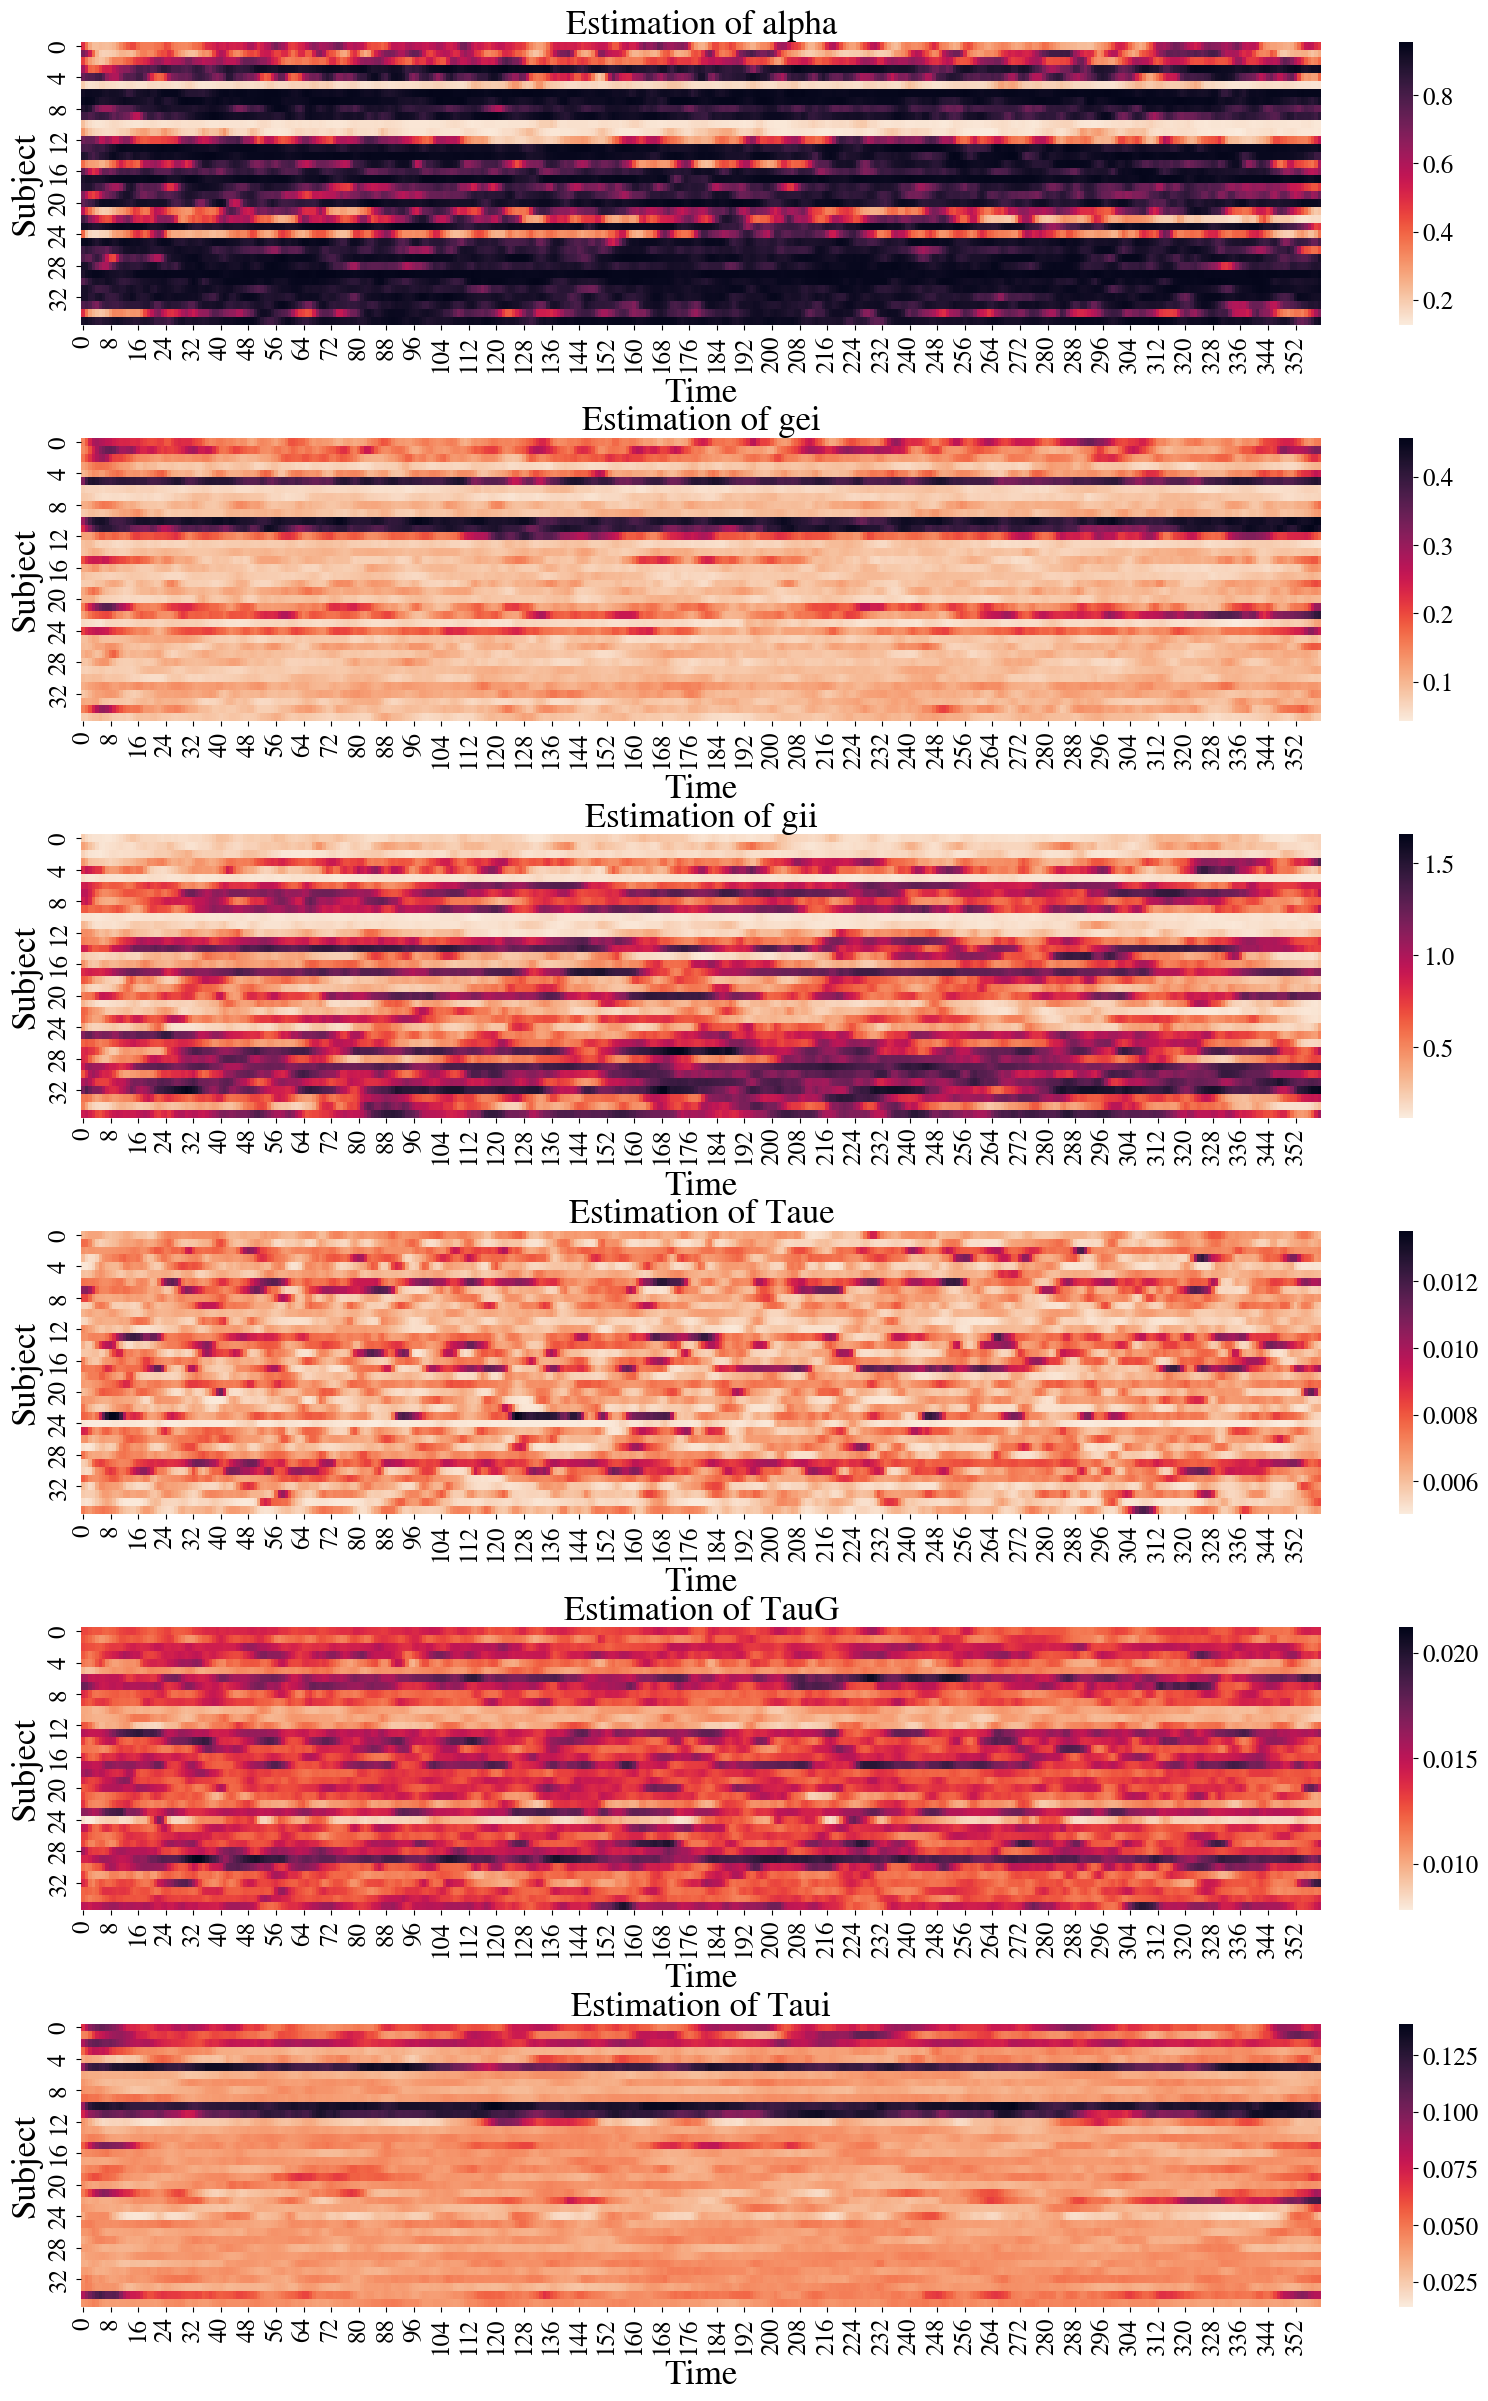

In [53]:
if not run_python_script:
    plt.figure(figsize=[20, 5*np.sum(dy_mask)])
    flag = 0
    for ix in range(7):
        if dy_mask[ix] == 1:
            plt.subplot(np.sum(dy_mask), 1, flag+1)
            plt.title(f"Estimation of {paras.names[ix]}", fontsize=25)
            sns.heatmap(sgm_paramss_est[:, :, ix], cmap="rocket_r")
            plt.xlabel("Time")
            plt.ylabel("Subject")
            flag+=1

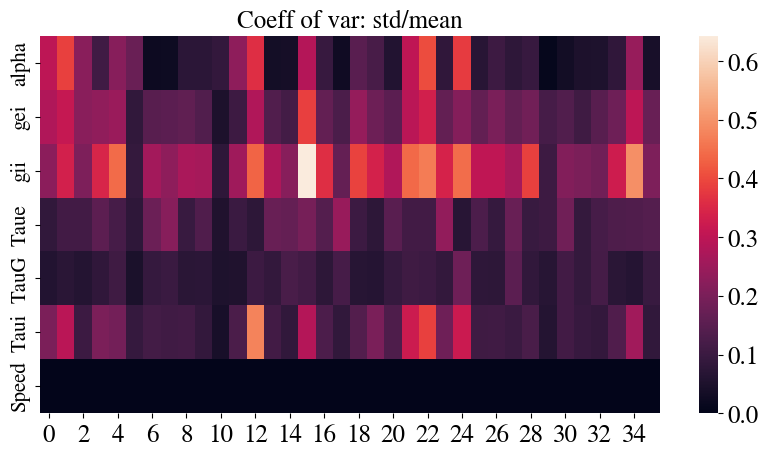

In [54]:
# coefficient of variation, CV=std/mean
if not run_python_script:
    cv1 = sgm_paramss_est.std(axis=1)/sgm_paramss_est.mean(axis=1);
    sns.heatmap(cv1.T)
    plt.yticks(np.arange(7)+0.5, paras.names, fontsize=15);
    plt.title("Coeff of var: std/mean");

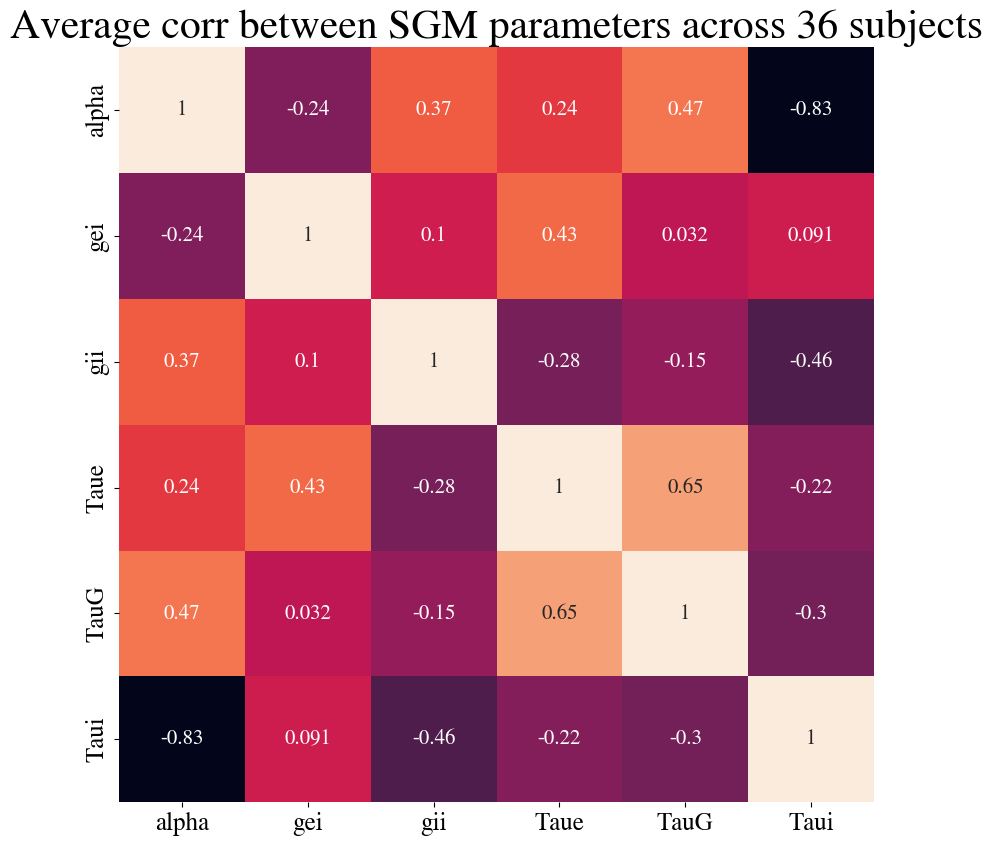

In [46]:
if not run_python_script:
    corr_mat = np.array([np.corrcoef(sgm_params_est[:, dy_mask==1].T) for sgm_params_est in sgm_paramss_est]).mean(axis=0)
    plt.figure(figsize=[10, 10])
    plt.title(f"Average corr between SGM parameters across 36 subjects", fontsize=30)
    sns.heatmap(corr_mat, square=True, annot=True, cbar=False,
                annot_kws=dict(fontsize=15))
    plt.xticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1])
    plt.yticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1]);

### Example

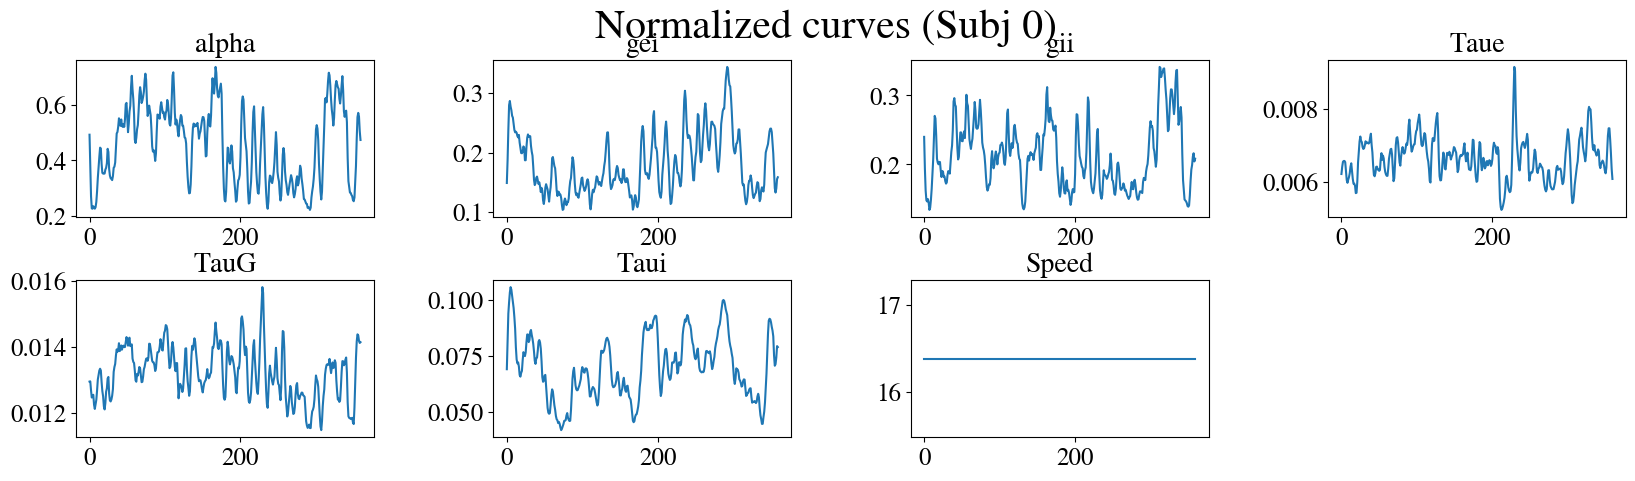

In [55]:
if not run_python_script:
    sub_idx = 0
    sgm_params_est = sgm_paramss_est[sub_idx]
    plt.figure(figsize=[20, 5])
    plt.suptitle(f"Normalized curves (Subj {sub_idx})", fontsize=30)
    for ix in range(7):
        plt.subplot(2, 4, ix+1)
        plt.plot(sgm_params_est[:, ix])
        plt.title(paras.names[ix], fontsize=20)

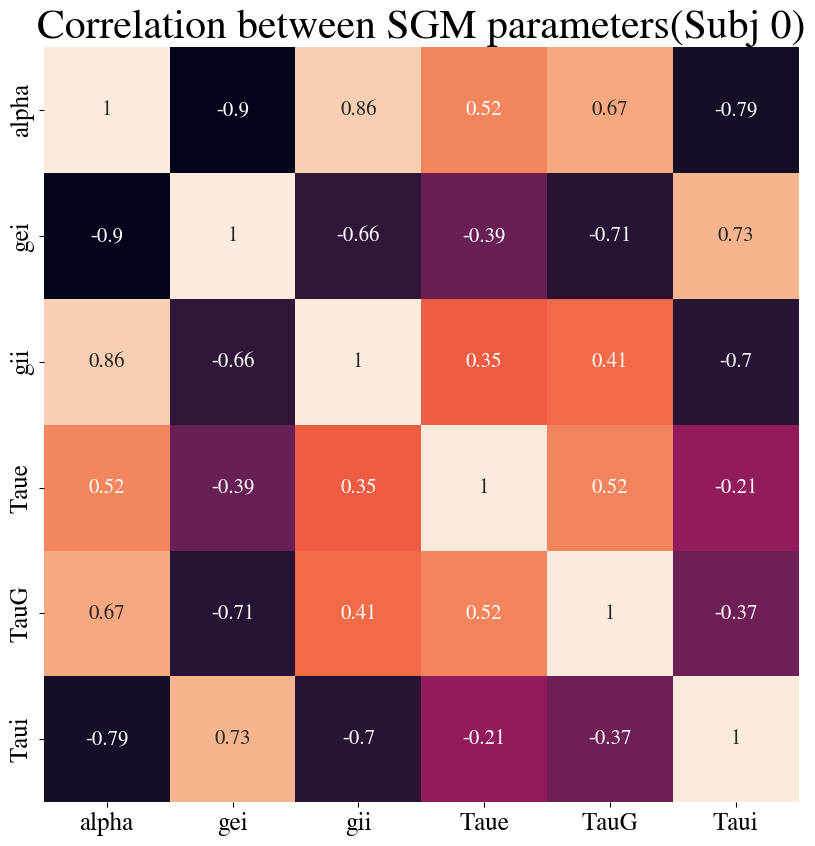

In [56]:
if not run_python_script:
    plt.figure(figsize=[10, 10])
    plt.title(f"Correlation between SGM parameters(Subj {sub_idx})", fontsize=30)
    sns.heatmap(np.corrcoef(sgm_params_est[:, dy_mask==1].T), square=True, annot=True, cbar=False,
                annot_kws=dict(fontsize=15))
    plt.xticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1])
    plt.yticks(np.arange(dy_mask.sum())+0.5, paras.names[dy_mask==1]);

### PSD

In [57]:
# calculate rec PSD and save, only need once
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
if "Rec_PSD" not in trained_model_lstm.keys():
    X_recs = []
    for sgm_params_est in sgm_paramss_est:
        X_rec = []
        for sgm_param in tqdm(sgm_params_est):
            cur_PSD = sgmmodel.run_local_coupling_forward(sgm_param)
            X_rec.append(cur_PSD[:68])
        X_recs.append(X_rec)
    # save
    trained_model_lstm.Rec_PSD = np.array(X_recs)
    save_pkl_dict2folder(RES_ROOT/f"LSTM_simu_net{fixed}", trained_model_lstm, is_force=False)
else:
    Rec_PSD = trained_model_lstm.Rec_PSD

In [58]:
X_recs = 20*np.log10(trained_model_lstm.Rec_PSD)
all_data = psd_all.transpose(3, 2, 0, 1)
X_recs_std = (X_recs - X_recs.mean(axis=-1, keepdims=True))/X_recs.std(axis=-1, keepdims=True)
all_data_std = (all_data - all_data.mean(axis=-1, keepdims=True))/all_data.std(axis=-1, keepdims=True);

In [59]:
if "corrss" not in trained_model_lstm.keys():
    corrss = []
    corrss_roiwise = []
    for X_org, X_rec in tqdm(zip(all_data_std, X_recs_std), total=len(X_recs_std)):
        corrs = []
        corrs_roiwise = []
        for ix in range(len(X_org)):
            res =ana_corr(X_org[ix], X_rec[ix])
            
            corrs.append(res[0])
            corrs_roiwise.append(np.mean(res[1]))
        
        corrss.append(corrs)
        corrss_roiwise.append(corrs_roiwise)
        
    trained_model_lstm.corrss = corrss
    trained_model_lstm.corrss_roiwise = corrss_roiwise
    save_pkl_dict2folder(RES_ROOT/f"LSTM_simu_net{fixed}", trained_model_lstm, is_force=False)
else:
    corrss = trained_model_lstm.corrss
    corrss_roiwise = trained_model_lstm.corrss_roiwise
    

In [60]:
np.mean(np.array(corrss_roiwise))

0.8385726498583065

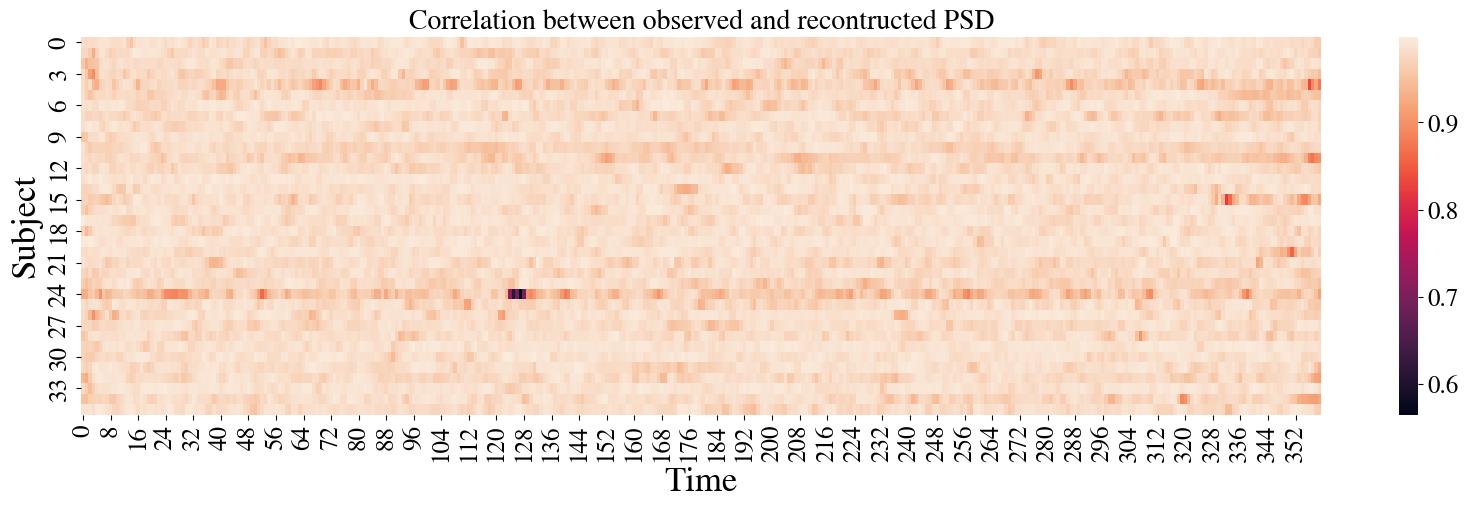

In [62]:
corrss_roiwise = np.array(corrss_roiwise)
corrss = np.array(corrss)
plt.figure(figsize=[20, 5])
plt.title("Correlation between observed and recontructed PSD", fontsize=20)
sns.heatmap(corrss, cmap="rocket")
plt.xlabel("Time")
plt.ylabel("Subject");

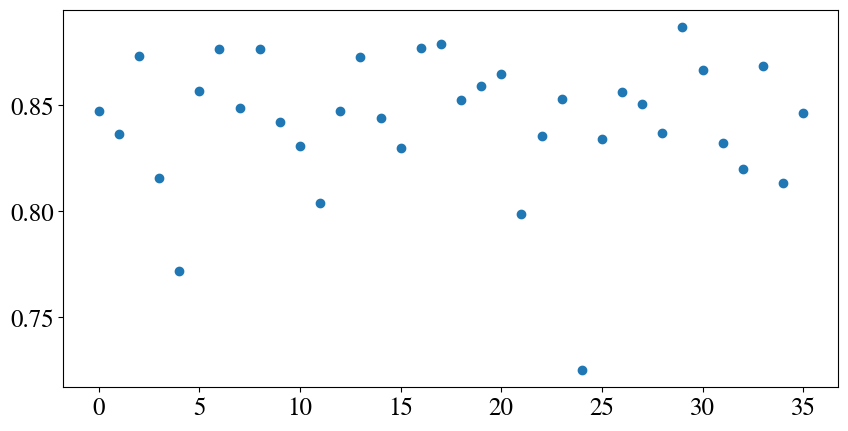

In [64]:
plt.plot(np.median(corrss_roiwise.mean(axis=-1), axis=1), "o")

In [65]:
np.argsort(corrss.mean(axis=-1))

array([24,  4, 11, 10,  3, 23,  7, 34, 15, 32,  5, 21, 25, 12, 28, 27,  1,
       22,  2, 35, 31, 26,  6, 18, 20, 17, 14,  8, 16,  9, 30,  0, 19, 33,
       13, 29])

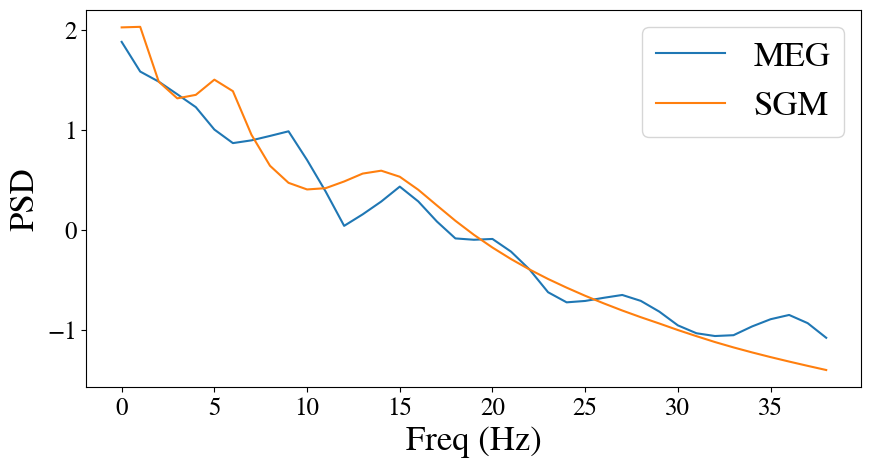

In [66]:
# example
sub_idx = 29
time_idx = 2
plt.plot(std_mat(all_data_std[sub_idx, time_idx]).mean(axis=0), label="MEG")
plt.plot(std_mat(X_recs[sub_idx, time_idx]).mean(axis=0), label="SGM")
plt.xlabel("Freq (Hz)")
plt.ylabel("PSD")
plt.legend()

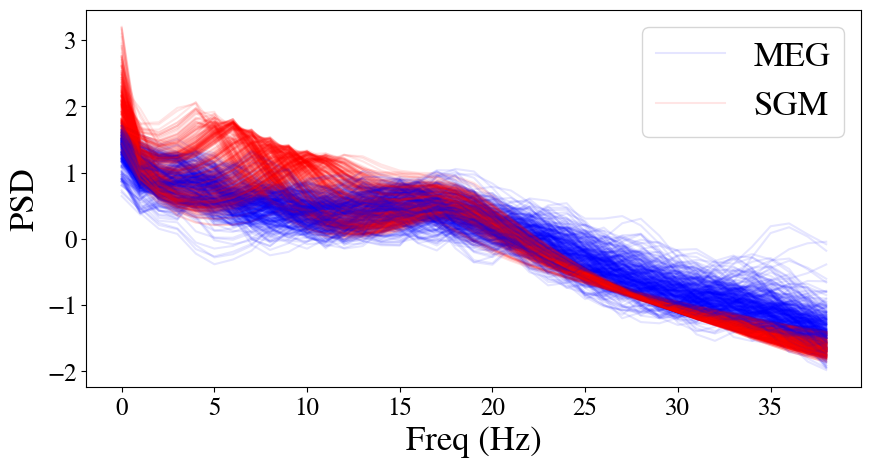

In [38]:
sub_idx = 24 # best 2, 23
#sub_idx = 24 # worst 12, 24
for ix in range(360):
    if ix == 0:
        plt.plot(std_mat(all_data_std[sub_idx, ix]).mean(axis=0), color="blue", alpha=0.1, label="MEG")
        plt.plot(std_mat(X_recs_std[sub_idx, ix]).mean(axis=0), color="red", alpha=0.1, label="SGM")
    else:
        plt.plot(std_mat(all_data_std[sub_idx, ix]).mean(axis=0), color="blue", alpha=0.1)
        plt.plot(std_mat(X_recs_std[sub_idx, ix]).mean(axis=0), color="red", alpha=0.1)
plt.xlabel("Freq (Hz)")
plt.ylabel("PSD")
plt.legend()

# Compare three ways

Alpha is always dynamic and speed is always static.

1. Only speed static

2. Speed and taus static

3. Gains and speed Static

In [93]:
res_names = ["Speed only", "Speed and Tau", "Speed and Gain"]

['Speed only', 'Speed and Tau', 'Speed and Gain']

In [94]:
res1 = load_pkl_folder2dict(RES_ROOT/f"LSTM_simu_net_corr", excluding=['opt*', "loss_fn"], verbose=True);
res2 = load_pkl_folder2dict(RES_ROOT/f"LSTM_simu_net_corr_tau", excluding=['opt*', "loss_fn"], );
res3 = load_pkl_folder2dict(RES_ROOT/f"LSTM_simu_net_corr_gain", excluding=['opt*', "loss_fn"]);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr/Rec_PSD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr/corrss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr/corrss_roiwise.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr/sgm_paramss_est.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_corr_tau/Rec_PSD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-S

In [95]:
# std
all_data = psd_all.transpose(3, 2, 0, 1);
all_data_std = (all_data - all_data.mean(axis=-1, keepdims=True))/all_data.std(axis=-1, keepdims=True);
res1.Rec_PSD_std = (res1.Rec_PSD- res1.Rec_PSD.mean(axis=-1, keepdims=True))/res1.Rec_PSD.std(axis=-1, keepdims=True)
res2.Rec_PSD_std = (res2.Rec_PSD- res2.Rec_PSD.mean(axis=-1, keepdims=True))/res2.Rec_PSD.std(axis=-1, keepdims=True)
res3.Rec_PSD_std = (res3.Rec_PSD- res3.Rec_PSD.mean(axis=-1, keepdims=True))/res3.Rec_PSD.std(axis=-1, keepdims=True)

In [96]:
res_three = [res1, res2, res3]
corrss_three = np.array([res.corrss for res in res_three])
corrss_roiwise_three = np.array([res.corrss_roiwise for res in res_three]);

In [97]:
np.median(np.array(corrss_roiwise_three)[:, 24, :], axis=1)

array([0.72378619, 0.71693488, 0.72487731])

In [98]:
np.median(np.array(corrss_roiwise_three), axis=(1, 2))

array([0.84838467, 0.84477879, 0.8483558 ])

In [99]:
# T test #TBD
import scipy
corrss_roiwise_three = np.array(corrss_roiwise_three);
pv1 = scipy.stats.ttest_ind(
    corrss_roiwise_three[0].reshape(-1), 
    corrss_roiwise_three[1].reshape(-1)).pvalue
pv2 = scipy.stats.ttest_ind(
    corrss_roiwise_three[0].reshape(-1), 
    corrss_roiwise_three[2].reshape(-1)).pvalue
print(f"Pvalue between {res_names[0]} vs {res_names[1]} is {pv1:.3E}")
print(f"Pvalue between {res_names[0]} vs {res_names[2]} is {pv2:.3E}")

Pvalue between Speed only vs Speed and Tau is 8.583E-12
Pvalue between Speed only vs Speed and Gain is 6.992E-01


Text(0, 0.5, "Pearson's R")

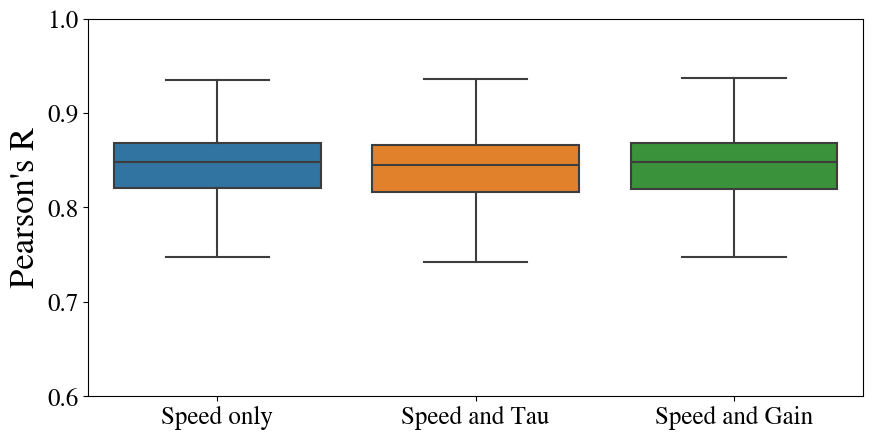

In [100]:
sns.boxplot(data=corrss_roiwise_three.reshape(3, -1).T, fliersize=0)
plt.xticks([0, 1, 2], res_names)
plt.ylim([0.6, 1.0])
plt.ylabel("Pearson's R")

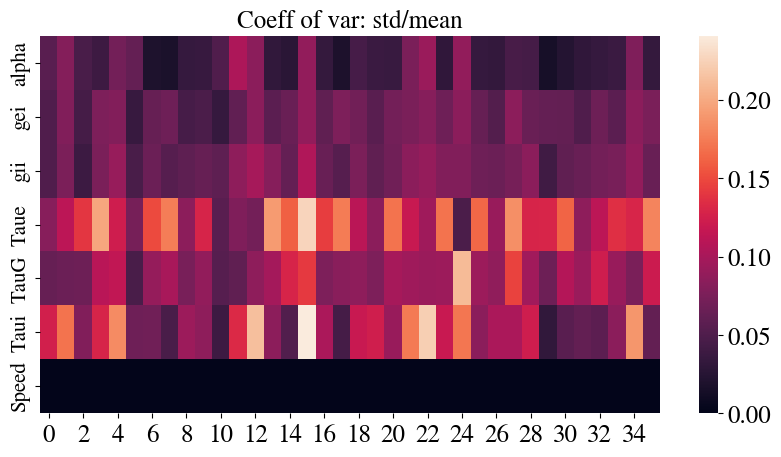

In [101]:
sgm_paramss_est_three = [res.sgm_paramss_est for res in res_three]
# coefficient of variation, CV=std/mean
idx = 0
cv1 = sgm_paramss_est_three[idx].std(axis=1)/sgm_paramss_est_three[idx].mean(axis=1);
sns.heatmap(cv1.T)
plt.yticks(np.arange(7)+0.5, paras.names, fontsize=15);
plt.title("Coeff of var: std/mean");

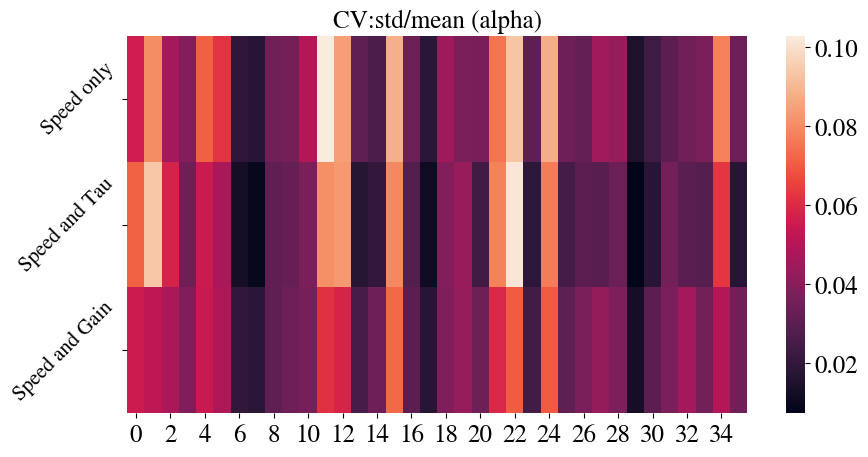

In [102]:
# coefficient of variation, CV=std/mean
cv2 = sgm_paramss_est_three[1].std(axis=1)/sgm_paramss_est_three[1].mean(axis=1);
cv3 = sgm_paramss_est_three[2].std(axis=1)/sgm_paramss_est_three[2].mean(axis=1);

param_name = "alpha"
param_idx = list(paras.names).index(param_name)
dat = [cv1[:, param_idx], 
       cv2[:, param_idx], 
       cv3[:, param_idx]]
sns.heatmap(dat) 
plt.title(f"CV:std/mean ({param_name})")
plt.yticks(np.arange(3)+0.5, res_names, fontsize=15, rotation=45);

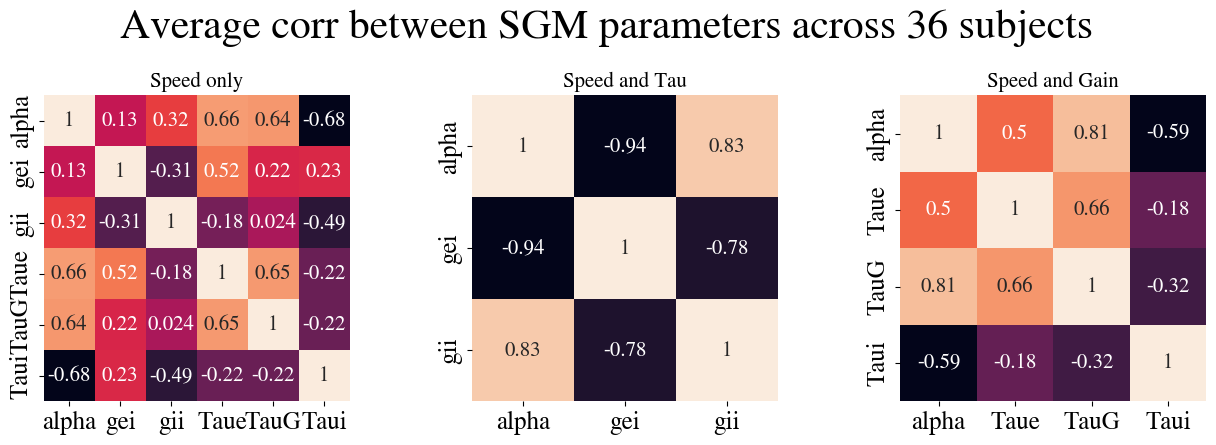

In [103]:
plt.figure(figsize=[15, 5])
plt.suptitle(f"Average corr between SGM parameters across 36 subjects", fontsize=30)
for ix in range(3):
    plt.subplot(1, 3, ix+1)
    plt.title(res_names[ix], fontsize=15)
    corr_mat = np.array([np.corrcoef(sgm_params_est[:, np.array(res_three[ix].paras.dy_mask)==1].T) 
                         for sgm_params_est in sgm_paramss_est_three[ix]]).mean(axis=0)
    sns.heatmap(corr_mat, square=True, annot=True, cbar=False,
                annot_kws=dict(fontsize=15))
    plt.xticks(np.arange(np.sum(res_three[ix].paras.dy_mask))+0.5, paras.names[np.array(res_three[ix].paras.dy_mask)==1])
    plt.yticks(np.arange(np.sum(res_three[ix].paras.dy_mask))+0.5, paras.names[np.array(res_three[ix].paras.dy_mask)==1]);

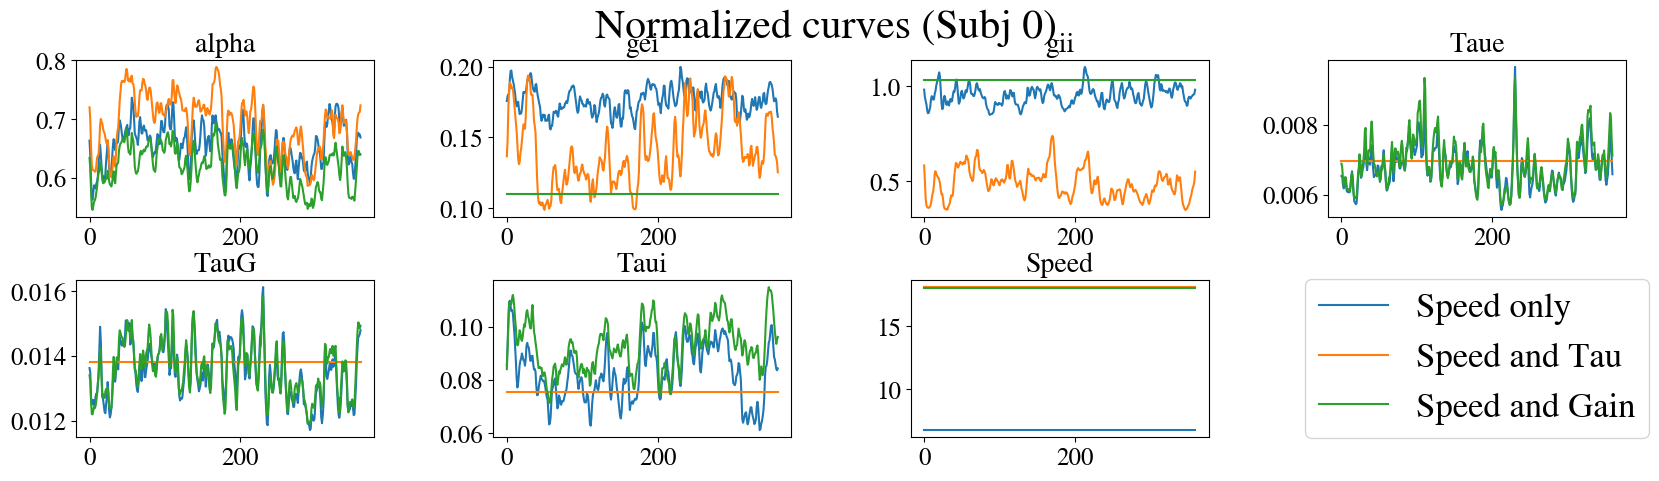

In [104]:
# sample
sub_idx = 0
#time_idx = 0
sgm_params_est1 = sgm_paramss_est_three[0][sub_idx]
sgm_params_est2 = sgm_paramss_est_three[1][sub_idx]
sgm_params_est3 = sgm_paramss_est_three[2][sub_idx]
plt.figure(figsize=[20, 5])
plt.suptitle(f"Normalized curves (Subj {sub_idx})", fontsize=30)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    plt.plot(sgm_params_est1[:, ix], label=res_names[0])
    plt.plot(sgm_params_est2[:, ix], label=res_names[1])
    plt.plot(sgm_params_est3[:, ix], label=res_names[2])
    plt.title(paras.names[ix], fontsize=20)
    
plt.subplot(2, 4, 8)
plt.axis('off')

fig = plt.gcf()
axes = fig.get_axes()
ax = axes[0]
handles, labels = [], []
for h, l in zip(*ax.get_legend_handles_labels()):
    handles.append(h)
    labels.append(l)

plt.legend(handles, labels, loc='center')